# NLP Analysis of Mobile Phone Reviews

**Module:** PUSL3189 – Natural Language Processing  
**Dataset:** Amazon Unlocked Mobile Reviews  
**Student:** *Hewa Waduge Sithum Sankajith Waduge*  

This notebook implements the full NLP pipeline used in the coursework report, including:

- Text preprocessing and tokenisation  
- TF–IDF feature extraction  
- POS tagging and Named Entity Recognition  
- Topic modelling (LDA + BERTopic)  
- Sentiment analysis and aspect-based sentiment  
- Dimensionality reduction and clustering  
- Advanced transformer-based analysis:
  - BERTopic topic summaries
  - Zero-shot classification
  - Semantic similarity search
  - Topic strength vs weakness analysis
  - Emotion detection
  - Toxicity detection
  - Interactive visualisations (Plotly)

Each section is aligned with the report structure (Sections 2–4).


## 0. Setup and Imports

This section installs required libraries (if necessary), imports Python packages, and sets global configuration such as random seeds and plotting styles.


In [1]:
import pandas as pd
import numpy as np
import re
import string
import random

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize

In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /home/sithum/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/sithum/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/sithum/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/sithum/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## 1. Data Loading

Here we:

1. Load the `Amazon_Unlocked_Mobile.csv` dataset.  

In [3]:
DATA_PATH = "./dataset/Amazon_Unlocked_Mobile.csv"

In [4]:
df = pd.read_csv(DATA_PATH)

## 2. Part A – Text Preprocessing

1. Drop rows with missing review text.  
2. Randomly sample 2,000 reviews for computational feasibility.  
3. Create the `Original` text column used throughout the notebook.
4. Clean text (lowercasing, remove HTML, URLs, digits, punctuation).  
5. Tokenise and remove stopwords using NLTK.  
6. Apply stemming (Porter) and lemmatisation (WordNet).  
7. Create a comparison table with 5 random examples:
  - `Original`
  - `Cleaned`
  - `Stemmed`
  - `Lemmatized`


In [5]:
# ------------------------------------------------------------
# 1. Dataset cleaning (drop missing + duplicates + filtering)
# ------------------------------------------------------------

# Drop rows with missing Reviews column
df = df.dropna(subset=['Reviews'])

# Remove duplicate reviews
df = df.drop_duplicates(subset=['Reviews'])

# Take 2000-sample for feasibility
df_sample = df.sample(n=2000, random_state=42).reset_index(drop=True)

# Standard text column
df_sample['Original'] = df_sample['Reviews'].astype(str)

# Length-based filters (remove ultra short / long reviews)
df_sample['word_len'] = df_sample['Original'].str.split().str.len()

df_sample = df_sample[
    (df_sample['word_len'] >= 5) &
    (df_sample['word_len'] <= 300)
].reset_index(drop=True)

print("Remaining reviews after cleaning:", len(df_sample))

Remaining reviews after cleaning: 1765


In [6]:
# ------------------------------------------------------------
# 2. ADVANCED CLEANING FUNCTIONS
# ------------------------------------------------------------

stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()


def normalize_whitespace(text):
    return re.sub(r'\s+', ' ', text).strip()


def remove_html(text):
    return re.sub(r'<.*?>', ' ', text)


def remove_urls(text):
    return re.sub(r'http\S+|www\.\S+', ' ', text)


def remove_user_mentions(text):
    return re.sub(r'@\w+', ' ', text)


def normalize_repeated_chars(text):
    # "goooood" -> "goood"
    return re.sub(r'(.)\1{2,}', r'\1\1', text)


def clean_text(text: str) -> str:
    text = str(text).lower()
    text = remove_html(text)
    text = remove_urls(text)
    text = remove_user_mentions(text)
    text = normalize_repeated_chars(text)

    # Remove digits
    text = re.sub(r'\d+', ' ', text)

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Normalize whitespace
    text = normalize_whitespace(text)
    return text


# -------------------------------
# Tokenization + stopword removal
# -------------------------------
def tokenize_and_remove_stopwords(text: str):
    tokens = word_tokenize(text)
    tokens = [
        t for t in tokens
        if t not in stop_words
        and len(t) > 2
        and any(ch.isalpha() for ch in t)
    ]
    return tokens


# -------------------------------
# Stemming
# -------------------------------
def stem_tokens(tokens):
    return [stemmer.stem(t) for t in tokens]


# -------------------------------
# Lemmatization
# -------------------------------
def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(t) for t in tokens]

In [7]:
# ------------------------------------------------------------
# 3. Apply the preprocessing steps
# ------------------------------------------------------------

# Step 1: Cleaning
df_sample['Cleaned'] = df_sample['Original'].apply(clean_text)

# Step 2: Tokenization + stopwords
df_sample['Tokens'] = df_sample['Cleaned'].apply(tokenize_and_remove_stopwords)

# Step 3: Stemming + Lemmatization
df_sample['Stemmed_Tokens'] = df_sample['Tokens'].apply(stem_tokens)
df_sample['Lemmatized_Tokens'] = df_sample['Tokens'].apply(lemmatize_tokens)

# Step 4: Convert back to text form
df_sample['Stemmed'] = df_sample['Stemmed_Tokens'].apply(lambda toks: " ".join(toks))
df_sample['Lemmatized'] = df_sample['Lemmatized_Tokens'].apply(lambda toks: " ".join(toks))

In [8]:
sample_rows = df_sample.sample(n=5, random_state=123).copy()
preview_table = sample_rows[['Original', 'Cleaned', 'Stemmed', 'Lemmatized']]
preview_table

,Original,Cleaned,Stemmed,Lemmatized
1503,"While I'm more used to smart phones, this is p...",while im more used to smart phones this is per...,use smart phone perfect mom isnt comfort techn...,used smart phone perfect mom isnt comfortable ...
310,Mine was working propertly only one week and w...,mine was working propertly only one week and w...,mine work propertli one week wasnt abl reboot ...,mine working propertly one week wasnt able reb...
1736,"The mobile arrived quickly, but does not work ...",the mobile arrived quickly but does not work p...,mobil arriv quickli work properli read micro sim,mobile arrived quickly work properly read micr...
598,My grandson is using the Alias and he really l...,my grandson is using the alias and he really l...,grandson use alia realli like like stay charg ...,grandson using alias really like like stay cha...
558,"It seemed like a really nice phone, until I tr...",it seemed like a really nice phone until i tri...,seem like realli nice phone tri activ report l...,seemed like really nice phone tried activate r...


## 3. Part B – TF–IDF Feature Extraction


- Build a TF–IDF vocabulary from the lemmatised reviews.  
- Create the sparse TF–IDF document–term matrix `X_tfidf`.  
- Identify the top-N terms by mean TF–IDF score.  
- Visualise these as:
  - A ranked table of terms.
  - A heatmap-style plot for the report.


In [9]:
# Part B – TF-IDF Feature Extraction

import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer


In [10]:
# ------------------------------------------------------------
# 1. Prepare corpus for TF–IDF (use lemmatised text from Part A)
# ------------------------------------------------------------
corpus = df_sample['Lemmatized'].astype(str).tolist()
print(f"Number of documents in corpus: {len(corpus)}")

Number of documents in corpus: 1765


In [11]:
# ------------------------------------------------------------
# 2. Construct an advanced TF–IDF representation
# ------------------------------------------------------------
# Design choices:
# - ngram_range=(1,2): include unigrams and bigrams
#   (e.g. "battery life", "screen protector")
# - sublinear_tf=True: use 1 + log(tf) instead of raw term frequency
# - min_df=5, max_df=0.8: ignore very rare and extremely common terms
# - norm='l2': make each document vector unit length

tfidf_vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),
    max_df=0.8,
    min_df=5,
    sublinear_tf=True,
    norm='l2',
    lowercase=False,   # we already lowercased in preprocessing
    stop_words=None    # stopwords removed earlier
)

X_tfidf = tfidf_vectorizer.fit_transform(corpus)
feature_names = np.array(tfidf_vectorizer.get_feature_names_out())

print("TF-IDF matrix shape:", X_tfidf.shape)  # (n_docs, n_terms)

TF-IDF matrix shape: (1765, 1590)


In [12]:
# ------------------------------------------------------------
# 3. Global top-N terms by mean TF-IDF
# ------------------------------------------------------------
top_n = 15

mean_tfidf = X_tfidf.mean(axis=0).A1  # mean value for each term
top_indices = mean_tfidf.argsort()[::-1][:top_n]

top_terms = feature_names[top_indices]
top_scores = mean_tfidf[top_indices]

tfidf_top_table = pd.DataFrame({
    "Rank": np.arange(1, top_n + 1),
    "Term": top_terms,
    "Mean_TF_IDF": top_scores
})

tfidf_top_table

,Rank,Term,Mean_TF_IDF
0,1,phone,0.067049
1,2,great,0.034717
2,3,work,0.030617
3,4,good,0.030584
4,5,love,0.026801
5,6,like,0.020602
6,7,one,0.020449
7,8,battery,0.019401
8,9,use,0.018638
9,10,product,0.017249


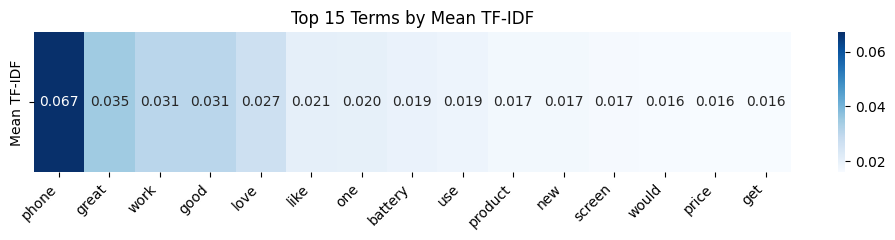

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_tfidf_top_terms_heatmap(X_tfidf, feature_names, top_n=20):
    mean_tfidf = X_tfidf.mean(axis=0).A1
    idx = mean_tfidf.argsort()[::-1][:top_n]
    terms = feature_names[idx]
    scores = mean_tfidf[idx]

    plt.figure(figsize=(10, 2.5))
    sns.heatmap(
        [scores],
        annot=True,
        fmt=".3f",
        yticklabels=["Mean TF-IDF"],
        xticklabels=terms,
        cmap="Blues"
    )
    plt.xticks(rotation=45, ha='right')
    plt.title(f"Top {top_n} Terms by Mean TF-IDF")
    plt.tight_layout()
    plt.show()

plot_tfidf_top_terms_heatmap(X_tfidf, feature_names, top_n=15)


In [14]:
# ------------------------------------------------------------
# 4. TF-IDF statistics for selected important words
# ------------------------------------------------------------

focus_terms = ["phone", "battery", "camera", "screen", "price", "delivery"]

rows = []
for term in focus_terms:
    # remember: feature_names contains both unigrams and bigrams
    mask = feature_names == term
    if mask.any():
        idx = np.where(mask)[0][0]
        col = X_tfidf[:, idx].toarray().ravel()

        doc_freq = int((col > 0).sum())       # in how many docs the term appears
        mean_score = float(col.mean())        # average TF-IDF across corpus
        max_score = float(col.max())          # highest TF-IDF for this term

        rows.append({
            "Term": term,
            "In_Vocabulary": True,
            "Doc_Freq": doc_freq,
            "Mean_TF_IDF": mean_score,
            "Max_TF_IDF": max_score
        })
    else:
        rows.append({
            "Term": term,
            "In_Vocabulary": False,
            "Doc_Freq": 0,
            "Mean_TF_IDF": np.nan,
            "Max_TF_IDF": np.nan
        })

focus_tfidf_table = pd.DataFrame(rows)
focus_tfidf_table


,Term,In_Vocabulary,Doc_Freq,Mean_TF_IDF,Max_TF_IDF
0,phone,True,1119,0.067049,0.478420
1,battery,True,226,0.019401,0.568488
2,camera,True,125,0.011494,0.605254
3,screen,True,204,0.016692,0.396626
4,price,True,156,0.015998,0.644497
5,delivery,True,11,0.002380,0.796637


## 4. Part C – POS Tagging and Named Entity Recognition

This section corresponds to **Section 2.3**.

We:

- Use spaCy to perform POS tagging and NER on sample reviews.  
- Display:
  - Tagged tokens (`token/POS`)
  - Named entities with labels (PRODUCT, ORG, DATE, etc.).  
- Aggregate frequent entities of type PRODUCT, ORG and DATE for inspection.


In [15]:
# Part C – POS Tagging & Named Entity Recognition

%pip install spacy
%pip install spacy[transformers]
!python -m spacy download en_core_web_sm

import pandas as pd
import spacy

nlp = spacy.load("en_core_web_sm")


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 943.4 kB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


/home/sithum/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
# ------------------------------------------------------------
# 1. POS + NER on a small sample for qualitative inspection
# ------------------------------------------------------------

pos_ner_sample = df_sample.sample(n=5, random_state=77).copy()

def get_pos_tags(doc):
    """Return a compact string like 'great/ADJ phone/NOUN ...' for a spaCy doc."""
    return " ".join([f"{token.text}/{token.pos_}" for token in doc])

def get_entities(doc):
    """Return entities as 'text (LABEL)' joined by commas."""
    if not doc.ents:
        return ""
    return ", ".join([f"{ent.text} ({ent.label_})" for ent in doc.ents])

docs = list(nlp.pipe(pos_ner_sample['Original'].tolist(), batch_size=16, n_process=1))

pos_tags_list = [get_pos_tags(doc) for doc in docs]
entities_list = [get_entities(doc) for doc in docs]

pos_ner_sample['POS_Tags'] = pos_tags_list
pos_ner_sample['Named_Entities'] = entities_list

pos_ner_preview = pos_ner_sample[['Original', 'POS_Tags', 'Named_Entities']]
pos_ner_preview

,Original,POS_Tags,Named_Entities
1010,The phone has the IMEI blocked by an Internati...,The/DET phone/NOUN has/AUX the/DET IMEI/PROPN ...,"IMEI (CARDINAL), an International Carrier (ORG)"
549,Was a day late but all and all a very good pro...,Was/AUX a/DET day/NOUN late/ADV but/CCONJ all/...,
34,Excellent product. Product as advertided by th...,Excellent/ADJ product/NOUN ./PUNCT Product/NOU...,
1664,I bought in April at $215. I used to be owner ...,I/PRON bought/VERB in/ADP April/PROPN at/ADP $...,"April (DATE), 215 (MONEY), Pantech Burst (PERS..."
1188,This phone is a complete piece of garbage! I j...,This/DET phone/NOUN is/AUX a/DET complete/ADJ ...,


,Count
NOUN,4076
VERB,3057
ADJ,1943
ADV,1553
PROPN,824


,Proportion
NOUN,0.355889
VERB,0.266917
ADJ,0.169650
ADV,0.135598
PROPN,0.071946


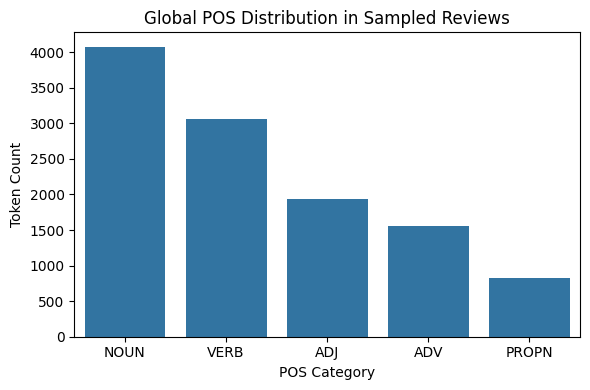

In [17]:
# ------------------------------------------------------------
# 2. POS statistics on a larger subset (how people write)
# ------------------------------------------------------------

from collections import Counter

# Take up to 500 reviews for speed
pos_subset = df_sample.sample(n=min(500, len(df_sample)), random_state=101).copy()

pos_rows = []
for doc, idx in zip(nlp.pipe(pos_subset['Original'].tolist(), batch_size=32, n_process=1),
                    pos_subset.index):
    counts = Counter([token.pos_ for token in doc])
    total_tokens = sum(counts.values()) or 1  # avoid division by zero

    row = {
        "index": idx,
        "NOUN": counts.get("NOUN", 0),
        "VERB": counts.get("VERB", 0),
        "ADJ": counts.get("ADJ", 0),
        "ADV": counts.get("ADV", 0),
        "PROPN": counts.get("PROPN", 0),
        "TOTAL_TOKENS": total_tokens
    }
    # Normalised proportions
    row.update({
        "NOUN_ratio": row["NOUN"] / total_tokens,
        "VERB_ratio": row["VERB"] / total_tokens,
        "ADJ_ratio": row["ADJ"] / total_tokens,
        "ADV_ratio": row["ADV"] / total_tokens,
        "PROPN_ratio": row["PROPN"] / total_tokens,
    })
    pos_rows.append(row)

pos_stats_df = pd.DataFrame(pos_rows).set_index("index")

# Global distribution of coarse POS categories
global_pos_counts = pos_stats_df[["NOUN", "VERB", "ADJ", "ADV", "PROPN"]].sum()
global_pos_ratios = global_pos_counts / global_pos_counts.sum()

display(global_pos_counts.to_frame("Count"))
display(global_pos_ratios.to_frame("Proportion"))

plt.figure(figsize=(6,4))
sns.barplot(x=global_pos_counts.index, y=global_pos_counts.values)
plt.title("Global POS Distribution in Sampled Reviews")
plt.xlabel("POS Category")
plt.ylabel("Token Count")
plt.tight_layout()
plt.show()


In [18]:
# OPTIONAL: POS distribution by sentiment (only runs if Sentiment column exists)

if "Sentiment" in df_sample.columns:
    # join sentiment onto pos_stats_df using the original indices
    pos_stats_with_sent = pos_stats_df.join(df_sample['Sentiment'])

    pos_by_sent = (
        pos_stats_with_sent
        .groupby('Sentiment')[["NOUN_ratio", "VERB_ratio", "ADJ_ratio", "ADV_ratio", "PROPN_ratio"]]
        .mean()
        .reset_index()
    )
    pos_by_sent
    plt.figure(figsize=(7,4))
    pos_by_sent_melted = pos_by_sent.melt(id_vars="Sentiment", var_name="POS", value_name="Mean_Ratio")
    sns.barplot(data=pos_by_sent_melted, x="POS", y="Mean_Ratio", hue="Sentiment")
    plt.title("Average POS Ratios by Sentiment (if VADER run)")
    plt.tight_layout()
    plt.show()


In [19]:
# ------------------------------------------------------------
# 3. Named Entity extraction and statistics
# ------------------------------------------------------------

# Use up to 500 reviews for NER stats
ner_subset = df_sample.sample(n=min(500, len(df_sample)), random_state=202).copy()

entity_counter = Counter()
label_counter = Counter()

for doc in nlp.pipe(ner_subset['Original'].tolist(), batch_size=32, n_process=1):
    for ent in doc.ents:
        entity_counter[(ent.text, ent.label_)] += 1
        label_counter[ent.label_] += 1

# Top 20 entity (text, label) combos
entity_rows = [
    {"Entity_Text": text, "Label": label, "Count": count}
    for (text, label), count in entity_counter.most_common(20)
]
entities_summary_df = pd.DataFrame(entity_rows)
entities_summary_df


,Entity_Text,Label,Count
0,first,ORDINAL,24
1,4,CARDINAL,23
2,3,CARDINAL,22
3,Samsung,ORG,20
4,one,CARDINAL,20
5,AT&T,ORG,15
6,BLU,ORG,15
7,2,CARDINAL,13
8,second,ORDINAL,11
9,Amazon,ORG,11


,Entity_Text,Count
2,S5,6
8,S4,3
4,Asus,3
1,Tuesday!I,1
0,the kitkat 4.4.4,1
5,Stars,1
3,Verus,1
6,V10,1
7,phones.pros-Durable,1
9,Iphone 6,1


,Entity_Text,Count
5,Samsung,20
6,AT&T,15
22,BLU,15
7,Amazon,11
24,Android,9
12,SIM,8
20,Motorola,7
31,iPhone,6
45,Nokia,5
62,S3,5


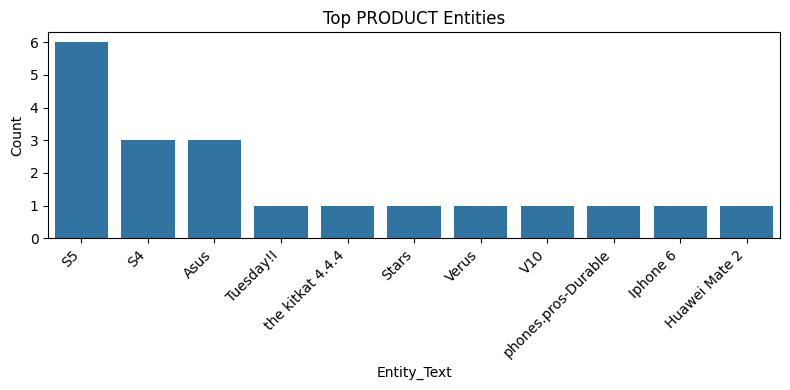

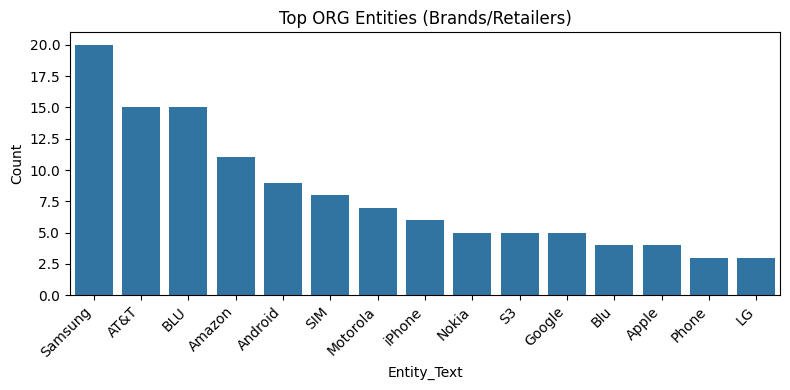

In [20]:
# Separate summary for PRODUCT and ORG entities (brands, products)

product_rows = [
    {"Entity_Text": text, "Count": count}
    for (text, label), count in entity_counter.items()
    if label == "PRODUCT"
]
org_rows = [
    {"Entity_Text": text, "Count": count}
    for (text, label), count in entity_counter.items()
    if label == "ORG"
]

product_df = pd.DataFrame(product_rows).sort_values("Count", ascending=False).head(15)
org_df = pd.DataFrame(org_rows).sort_values("Count", ascending=False).head(15)

display(product_df)
display(org_df)

plt.figure(figsize=(8,4))
sns.barplot(data=product_df, x="Entity_Text", y="Count")
plt.title("Top PRODUCT Entities")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
sns.barplot(data=org_df, x="Entity_Text", y="Count")
plt.title("Top ORG Entities (Brands/Retailers)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


## 5. Part D – Topic Modelling

We apply both classical LDA and transformer-based BERTopic to discover themes in the reviews.


### 5.1 LDA Topic Modelling

- Build a Gensim dictionary and corpus from token lists.  
- Train an LDA model with 3 topics.  
- Print top words per topic and visualise with keyword bar charts.


In [21]:
# Part D – Topic Modelling (Advanced LDA)

# !pip install gensim

import gensim
from gensim import corpora
from gensim.models import CoherenceModel
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------------------------------------
# 1. Prepare tokens, dictionary and corpus for LDA
# ------------------------------------------------------------

texts = df_sample['Lemmatized_Tokens'].tolist()   # list of token lists

# Create dictionary mapping id -> word
id2word = corpora.Dictionary(texts)

# Filter extremes: remove very rare & very common tokens
id2word.filter_extremes(no_below=5, no_above=0.8)

# Bag-of-words corpus: list of lists of (token_id, count)
corpus = [id2word.doc2bow(text) for text in texts]

print(f"Dictionary size (vocabulary): {len(id2word)}")
print(f"Number of documents in corpus: {len(corpus)}")


Dictionary size (vocabulary): 1143
Number of documents in corpus: 1765


k=3 -> coherence=0.570
k=4 -> coherence=0.557
k=5 -> coherence=0.547
k=6 -> coherence=0.554


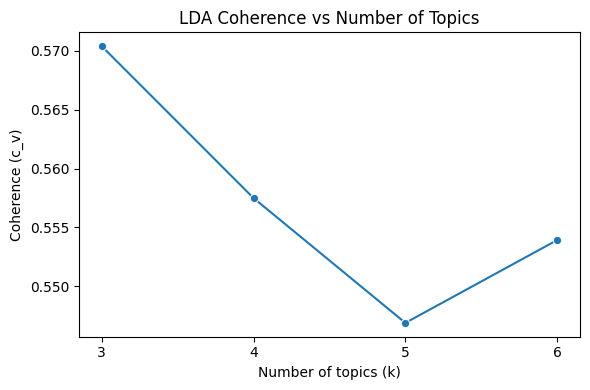


Selected number of topics (best coherence): k = 3


In [22]:
# ------------------------------------------------------------
# 2. Model selection: choose number of topics using coherence
# ------------------------------------------------------------

def train_lda(k):
    """Train an LDA model with k topics using sensible hyperparameters."""
    lda = gensim.models.LdaModel(
        corpus=corpus,
        id2word=id2word,
        num_topics=k,
        random_state=42,
        chunksize=2000,
        passes=10,
        alpha='auto',
        eta='auto',
        per_word_topics=True
    )
    return lda

topic_nums = [3, 4, 5, 6]
coherence_scores = []

for k in topic_nums:
    lda_k = train_lda(k)
    coherence_model = CoherenceModel(
        model=lda_k,
        texts=texts,
        dictionary=id2word,
        coherence='c_v'
    )
    coherence = coherence_model.get_coherence()
    coherence_scores.append(coherence)
    print(f"k={k} -> coherence={coherence:.3f}")

# Plot coherence vs number of topics
plt.figure(figsize=(6,4))
sns.lineplot(x=topic_nums, y=coherence_scores, marker="o")
plt.xlabel("Number of topics (k)")
plt.ylabel("Coherence (c_v)")
plt.title("LDA Coherence vs Number of Topics")
plt.xticks(topic_nums)
plt.tight_layout()
plt.show()

# Choose best k (highest coherence)
best_k = topic_nums[int(np.argmax(coherence_scores))]
print(f"\nSelected number of topics (best coherence): k = {best_k}")


In [23]:
# ------------------------------------------------------------
# 3. Train final LDA model with best_k topics
# ------------------------------------------------------------

lda_model = train_lda(best_k)

print("\n=== Final LDA Topics (top 10 words) ===")
for t in range(best_k):
    terms = lda_model.show_topic(t, topn=10)
    words = [w for w, p in terms]
    print(f"Topic {t}: {', '.join(words)}")



=== Final LDA Topics (top 10 words) ===
Topic 0: phone, work, great, one, get, time, like, battery, would, use
Topic 1: phone, work, screen, one, new, use, unlocked, great, like, camera
Topic 2: phone, good, great, work, product, battery, love, fast, price, excellent


In [24]:
# ------------------------------------------------------------
# 4. Assign dominant topic to each review
# ------------------------------------------------------------

def get_dominant_topic(lda_model, bow_doc):
    """
    Given a bag-of-words doc, return (topic_id, probability) of the most likely topic.
    """
    topics_probs = lda_model.get_document_topics(bow_doc, minimum_probability=0.0)
    if not topics_probs:
        return None, 0.0
    topic_id, prob = max(topics_probs, key=lambda x: x[1])
    return topic_id, prob

dominant_topics = []
topic_probs = []

for bow in corpus:
    tid, prob = get_dominant_topic(lda_model, bow)
    dominant_topics.append(tid)
    topic_probs.append(prob)

df_sample['LDA_Topic'] = dominant_topics
df_sample['LDA_Topic_Prob'] = topic_probs

df_sample[['Original', 'LDA_Topic', 'LDA_Topic_Prob']].head()


,Original,LDA_Topic,LDA_Topic_Prob
0,Same features as my wife's iPhone 6.at a third...,0,0.951292
1,This phone is good but some of the apps aren't...,2,0.581510
2,Love this phone! bought the same model to repl...,0,0.778061
3,"Shipped very fast, great phone",2,0.927920
4,"Nice product, arrived on time , would recommend!",2,0.950174


In [25]:
# ------------------------------------------------------------
# 5. Interpret topics with example reviews
# ------------------------------------------------------------

num_examples = 3  # how many example reviews per topic

for t in range(best_k):
    print(f"\n{'='*60}")
    print(f"TOPIC {t}")
    
    # Top keywords
    terms = lda_model.show_topic(t, topn=10)
    keywords = [w for w, p in terms]
    print("Top keywords:", ", ".join(keywords))
    
    # Example reviews (most confident for this topic)
    topic_docs = df_sample[df_sample['LDA_Topic'] == t]\
                 .sort_values('LDA_Topic_Prob', ascending=False)\
                 .head(num_examples)
    
    print("\nRepresentative reviews:")
    for i, row in topic_docs.iterrows():
        text_snippet = row['Original'][:250].replace("\n", " ")
        print(f"- (p={row['LDA_Topic_Prob']:.2f}) {text_snippet}...")



TOPIC 0
Top keywords: phone, work, great, one, get, time, like, battery, would, use

Representative reviews:
- (p=1.00) My experience with this purchase was a complete disaster. First, the Seller advertised it as a new phone. But when I received it, it already contained contacts, text messages and pictures. I contacted the Seller & he refunded part of my money since i...
- (p=1.00) The watch is internally set for GMT in which N.Y. is GMT-5:00 however nothing you can do to get it from AM to PM or vice versa so if you use the Stock digital face clock will be 24hrs off if you can set it at all. I hope the seller contacts me with a...
- (p=1.00) I tried, I gave it so many chances. It was just not a good phone. Let's see if I can remember all the wacky things it did. It would reboot itself randomly, maybe 2-4 times per day at least. Constantly told me there was a wifi available when I was alr...

TOPIC 1
Top keywords: phone, work, screen, one, new, use, unlocked, great, like, camera

Repre

## 6. Part E – Sentiment Analysis

We compute sentiment at two levels:

1. Overall review polarity using VADER.  
2. Aspect-level sentiment using dependency relations between nouns and adjectives.


In [26]:
# Part E – Advanced Sentiment Analysis with VADER

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

# nltk.download('vader_lexicon')  # run once

sid = SentimentIntensityAnalyzer()

# ------------------------------------------------------------
# 1. Prepare dataset for sentiment analysis
# ------------------------------------------------------------
# Ensure we work only with non-empty texts
sent_df = df_sample.copy()
sent_df = sent_df[sent_df['Original'].str.strip().str.len() > 0].reset_index(drop=True)

print("Number of reviews for sentiment analysis:", len(sent_df))

# ------------------------------------------------------------
# 2. Compute VADER scores + robust sentiment label
# ------------------------------------------------------------

def vader_scores(text: str):
    """Return full VADER score dict for a single review."""
    return sid.polarity_scores(str(text))

scores = sent_df['Original'].apply(vader_scores)
scores_df = scores.apply(pd.Series)   # columns: neg, neu, pos, compound

sent_df = pd.concat([sent_df, scores_df], axis=1)

def label_from_compound(c: float, pos_th=0.05, neg_th=-0.05):
    """Map compound score to discrete label."""
    if c >= pos_th:
        return "Positive"
    elif c <= neg_th:
        return "Negative"
    else:
        return "Neutral"

sent_df['Sentiment'] = sent_df['compound'].apply(label_from_compound)

# Copy back into df_sample so later parts use it too
df_sample[['neg', 'neu', 'pos', 'compound', 'Sentiment']] = sent_df[['neg', 'neu', 'pos', 'compound', 'Sentiment']]

sent_df[['Original', 'compound', 'Sentiment']].head()


Number of reviews for sentiment analysis: 1765


,Original,compound,Sentiment
0,Same features as my wife's iPhone 6.at a third...,0.0000,Neutral
1,This phone is good but some of the apps aren't...,0.7992,Positive
2,Love this phone! bought the same model to repl...,0.8655,Positive
3,"Shipped very fast, great phone",0.6573,Positive
4,"Nice product, arrived on time , would recommend!",0.6800,Positive


,Count,Percentage
Sentiment,,
Positive,1205,68.27
Neutral,157,8.90
Negative,403,22.83


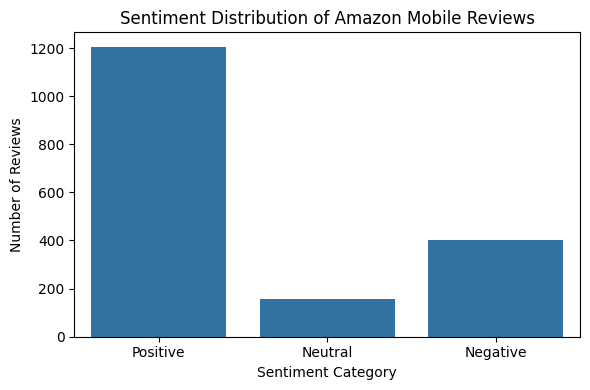

In [27]:
# ------------------------------------------------------------
# 3. Overall sentiment distribution (counts + percentages)
# ------------------------------------------------------------

sent_counts = sent_df['Sentiment'].value_counts().reindex(['Positive', 'Neutral', 'Negative']).fillna(0)
sent_perc = (sent_counts / sent_counts.sum() * 100).round(2)

display(pd.DataFrame({
    "Count": sent_counts.astype(int),
    "Percentage": sent_perc
}))

plt.figure(figsize=(6,4))
sns.countplot(x='Sentiment', data=sent_df, order=['Positive', 'Neutral', 'Negative'])
plt.title("Sentiment Distribution of Amazon Mobile Reviews")
plt.xlabel("Sentiment Category")
plt.ylabel("Number of Reviews")
plt.tight_layout()
plt.show()


Using rating column: Rating


,Rating,mean,median,count
0,1,-0.202761,-0.27550,355
1,2,-0.056883,0.00000,146
2,3,0.219438,0.27320,159
3,4,0.524497,0.63690,277
4,5,0.642738,0.77585,828


/tmp/ipykernel_21303/4158950337.py:28: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=rating_col, y='compound', data=rating_df, estimator=np.mean, ci=None)


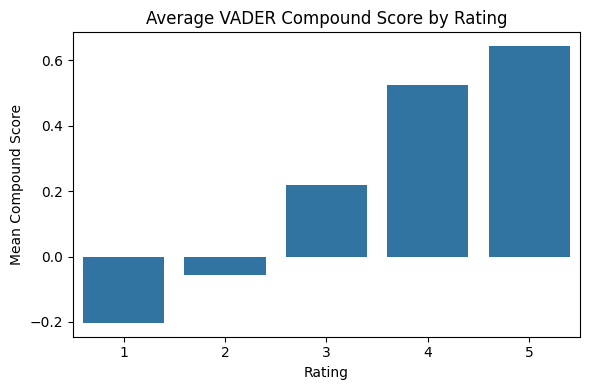

In [28]:
# ------------------------------------------------------------
# 4. Sentiment vs rating (if rating column exists)
#    -> very nice for analysis in the report
# ------------------------------------------------------------

rating_col = None
for col in df_sample.columns:
    if col.lower() in ['rating', 'stars', 'review_rating', 'score']:
        rating_col = col
        break

if rating_col is not None:
    print(f"Using rating column: {rating_col}")
    
    # Keep a copy with ratings
    rating_df = sent_df[[rating_col, 'compound', 'Sentiment']].dropna()
    
    # Mean sentiment per rating
    rating_stats = (
        rating_df.groupby(rating_col)['compound']
        .agg(['mean', 'median', 'count'])
        .reset_index()
        .sort_values(rating_col)
    )
    display(rating_stats)
    
    plt.figure(figsize=(6,4))
    sns.barplot(x=rating_col, y='compound', data=rating_df, estimator=np.mean, ci=None)
    plt.title("Average VADER Compound Score by Rating")
    plt.ylabel("Mean Compound Score")
    plt.tight_layout()
    plt.show()
else:
    print("No rating/stars column found – skipping sentiment vs rating plot.")


Using topic column for sentiment breakdown: LDA_Topic


,LDA_Topic,mean,median,std,count
0,0,0.200632,0.3182,0.590912,703
1,1,0.324046,0.4770,0.569181,532
2,2,0.601210,0.7592,0.407438,530


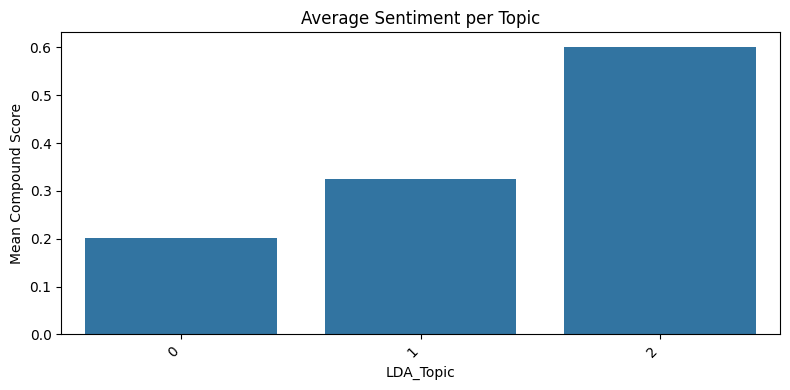

In [29]:
# ------------------------------------------------------------
# 5. Sentiment vs topic (if BERTopic or LDA topic already exists)
# ------------------------------------------------------------

topic_col = None
for candidate in ['Topic_Label', 'BERTopic_Topic', 'LDA_Topic']:
    if candidate in df_sample.columns:
        topic_col = candidate
        break

if topic_col is not None:
    print(f"Using topic column for sentiment breakdown: {topic_col}")
    
    topic_sent = (
        df_sample.groupby(topic_col)['compound']
        .agg(['mean', 'median', 'std', 'count'])
        .reset_index()
        .sort_values('mean')
    )
    display(topic_sent.head(10))
    
    plt.figure(figsize=(8,4))
    sns.barplot(x=topic_col, y='mean', data=topic_sent)
    plt.title("Average Sentiment per Topic")
    plt.ylabel("Mean Compound Score")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("No topic column found yet – run topic modelling first if you want this view.")


In [30]:
# ------------------------------------------------------------
# 6. Inspect likely misclassifications (for critical analysis)
# ------------------------------------------------------------

failure_cases = []

for _, row in sent_df.iterrows():
    text = str(row['Original'])
    label = row['Sentiment']
    c = row['compound']
    lower = text.lower()
    
    # Simple heuristic rules
    has_neg_word = any(w in lower for w in ["terrible", "awful", "worst", "refund", "broken"])
    has_pos_word = any(w in lower for w in ["amazing", "perfect", "awesome", "love", "excellent"])
    has_but = " but " in lower
    
    # suspicious combos:
    if (has_neg_word and label == "Positive") \
       or (has_pos_word and label == "Negative") \
       or (has_but and abs(c) > 0.2):
        failure_cases.append({
            "Text": text[:300].replace("\n", " "),
            "Label": label,
            "Compound": c
        })

failure_df = pd.DataFrame(failure_cases).head(8)
failure_df


,Text,Label,Compound
0,This phone is good but some of the apps aren't...,Positive,0.7992
1,"I had a bad experience with this one , but it ...",Negative,-0.9136
2,"I purchased used from JP Mobiles LLC, and I co...",Positive,0.7030
3,"Love this phone. Fairly quick page loading, ha...",Positive,0.8217
4,It's great but wanted it in dual SIM though mi...,Positive,0.3716
5,Be careful: I thought I was buying this phone ...,Negative,-0.5070
6,"So far it's been great, love everything bout t...",Positive,0.9068
7,"i like nokia phones ,i used few diffrent versi...",Positive,0.9499


## 7. Part F – Dimensionality Reduction and Clustering

This section corresponds to **Section 2.6**.

We:

- Reduce TF–IDF vectors to 2-D using PCA.  
- Visualise review clusters coloured by:
  - Sentiment
  - Topic label  
- Apply Ward hierarchical clustering and plot a dendrogram for a subset.


Explained variance by first 10 PCs: [0.0096538  0.00902611 0.00864814 0.00757992 0.00738193 0.00644444
 0.00618618 0.00591103 0.00559853 0.005312  ]
Cumulative variance by first 2 PCs: 0.018679912753506157


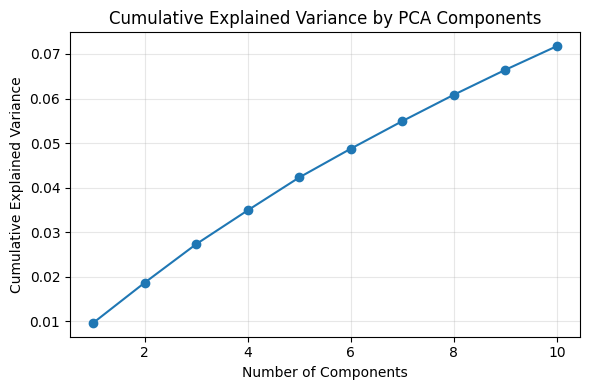

In [31]:
# Part F – Advanced PCA & Hierarchical Clustering

import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram

# ------------------------------------------------------------
# 1. PCA: project TF–IDF vectors to lower dimensions
# ------------------------------------------------------------

# For 2000 x ~1000 it's still ok to go to dense. If memory ever explodes, use TruncatedSVD instead.
X_dense = X_tfidf.toarray()

# Optional scaling (TF–IDF is already L2 normalised but scaling doesn't hurt)
# scaler = StandardScaler(with_mean=False)
# X_scaled = scaler.fit_transform(X_dense)
X_scaled = X_dense

# Keep more than 2 components to use for clustering, but visualise the first two.
pca = PCA(n_components=10, random_state=42)
X_pca_full = pca.fit_transform(X_scaled)

df_sample['PC1'] = X_pca_full[:, 0]
df_sample['PC2'] = X_pca_full[:, 1]

print("Explained variance by first 10 PCs:", pca.explained_variance_ratio_)
print("Cumulative variance by first 2 PCs:", pca.explained_variance_ratio_[:2].sum())

# Plot cumulative explained variance
cum_var = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(6,4))
plt.plot(np.arange(1, len(cum_var)+1), cum_var, marker='o')
plt.title("Cumulative Explained Variance by PCA Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


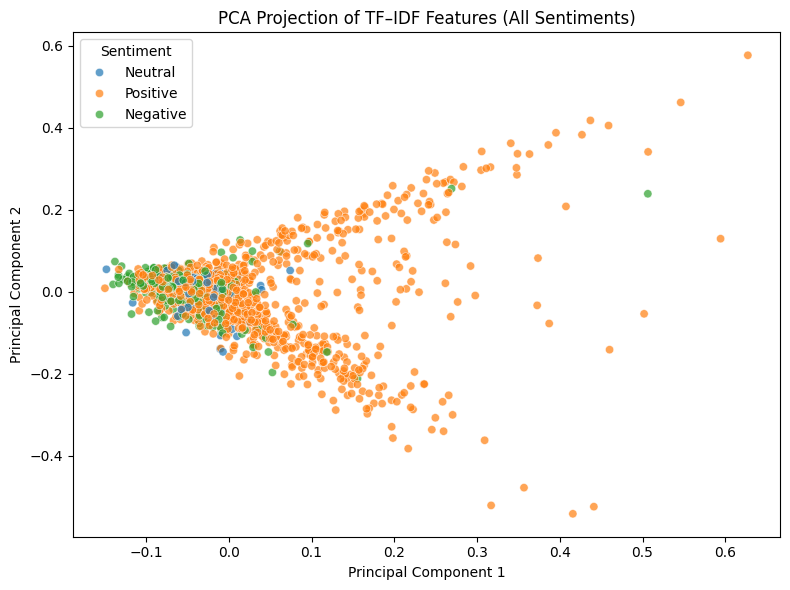

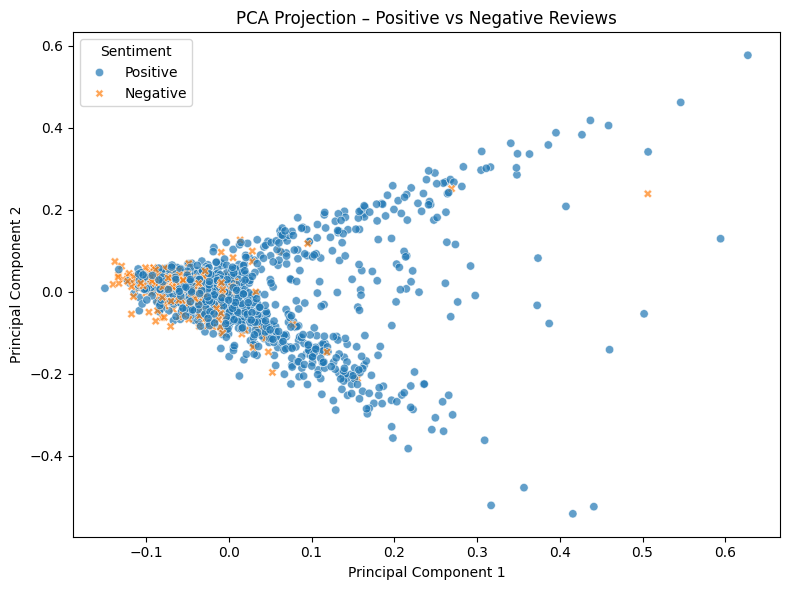

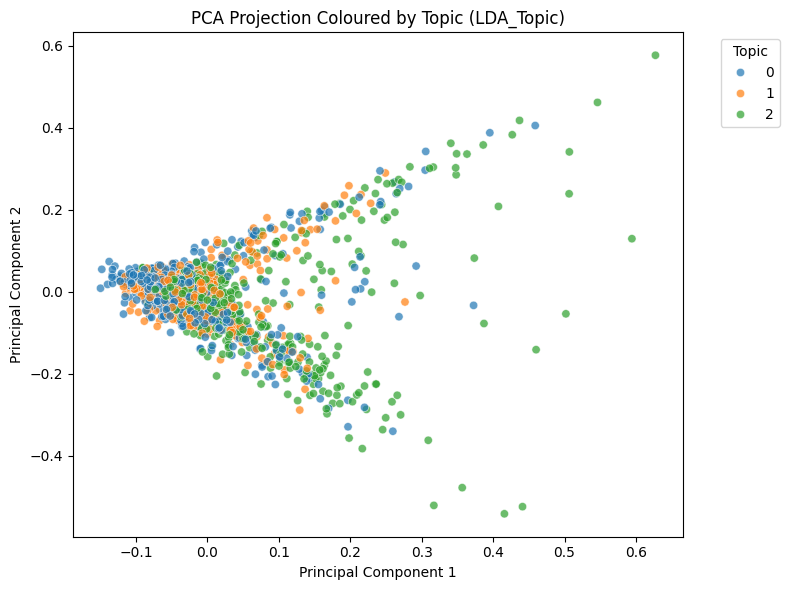

In [32]:
# ------------------------------------------------------------
# 2. Scatterplots of PCA space (sentiment & topic)
# ------------------------------------------------------------

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df_sample,
    x='PC1', y='PC2',
    hue='Sentiment',
    alpha=0.7
)
plt.title("PCA Projection of TF–IDF Features (All Sentiments)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()

# Positive vs Negative only (drop Neutral)
mask_pn = df_sample['Sentiment'].isin(['Positive', 'Negative'])
df_pn = df_sample[mask_pn].copy()

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df_pn,
    x='PC1', y='PC2',
    hue='Sentiment',
    style='Sentiment',
    alpha=0.7
)
plt.title("PCA Projection – Positive vs Negative Reviews")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()

# Optional: colour by topic label if available
topic_col = None
for candidate in ['Topic_Label', 'BERTopic_Topic', 'LDA_Topic']:
    if candidate in df_sample.columns:
        topic_col = candidate
        break

if topic_col is not None:
    plt.figure(figsize=(8,6))
    sns.scatterplot(
        data=df_sample,
        x='PC1', y='PC2',
        hue=topic_col,
        alpha=0.7,
        palette='tab10'
    )
    plt.title(f"PCA Projection Coloured by Topic ({topic_col})")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend(title="Topic", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
else:
    print("No topic column found yet – skipping PCA-by-topic plot.")


Hierarchical clustering silhouette score (k=4): 0.378


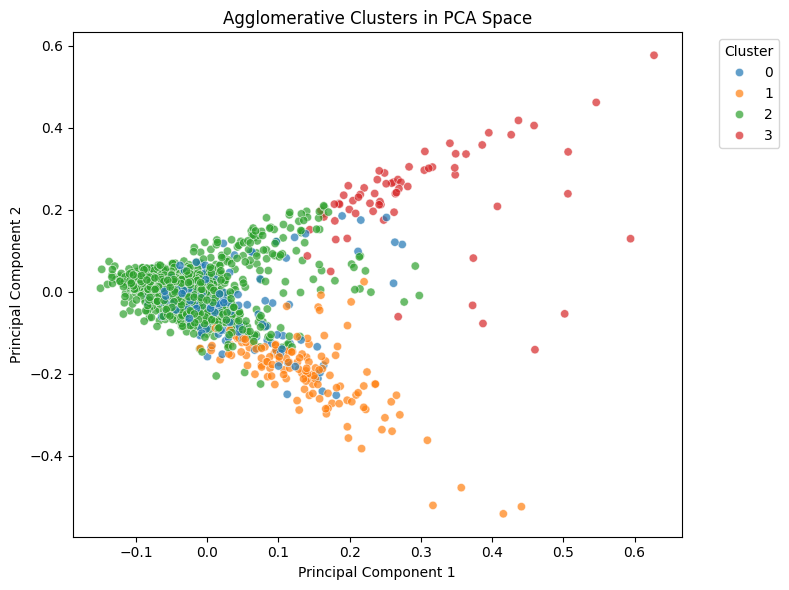

In [33]:
# ------------------------------------------------------------
# 3. Hierarchical clustering on PCA features
# ------------------------------------------------------------

# We'll cluster using the first few PCs (e.g., 5) to capture more structure
n_cluster_features = 5
X_cluster = X_pca_full[:, :n_cluster_features]

# Try a small number of clusters (e.g., k=4). You can tweak this.
k = 4
agg = AgglomerativeClustering(
    n_clusters=k,
    linkage='ward'
)
cluster_labels = agg.fit_predict(X_cluster)

df_sample['Cluster'] = cluster_labels

# Silhouette score gives a rough quality measure (higher is better, max≈1)
sil = silhouette_score(X_cluster, cluster_labels)
print(f"Hierarchical clustering silhouette score (k={k}): {sil:.3f}")

# Quick view: cluster centroids in PCA1/2 space
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df_sample,
    x='PC1', y='PC2',
    hue='Cluster',
    palette='tab10',
    alpha=0.7
)
plt.title("Agglomerative Clusters in PCA Space")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


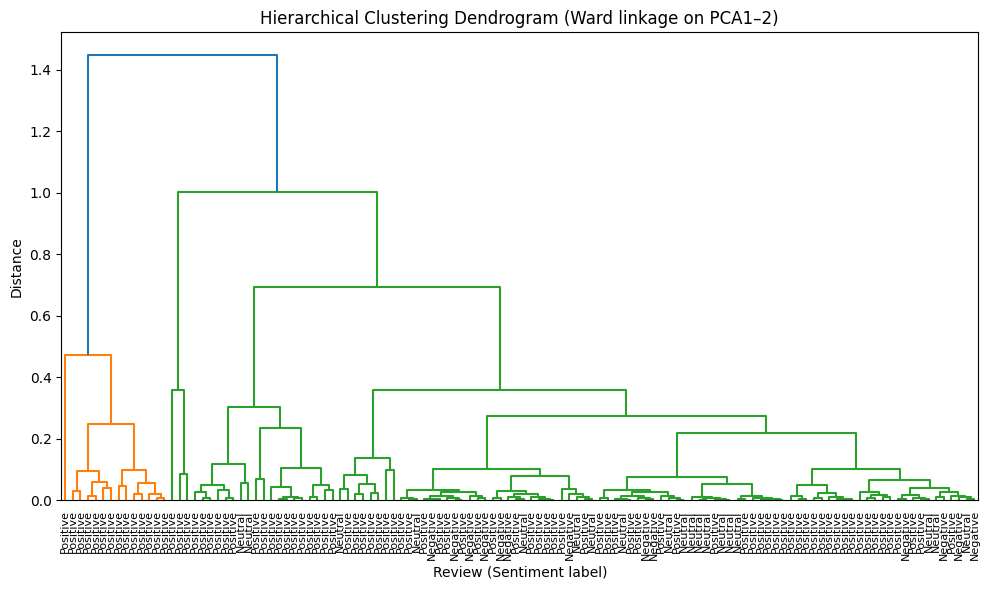

In [34]:
# ------------------------------------------------------------
# 4. Dendrogram on a subset (for visual hierarchy)
# ------------------------------------------------------------

subset_size = min(120, len(df_sample))
df_subset = df_sample.sample(n=subset_size, random_state=123)

X_subset = df_subset[['PC1', 'PC2']].values

Z = linkage(X_subset, method='ward')

plt.figure(figsize=(10, 6))
dendrogram(
    Z,
    labels=df_subset['Sentiment'].tolist(),  # or df_subset['Cluster'] if you prefer
    leaf_rotation=90,
    leaf_font_size=8
)
plt.title("Hierarchical Clustering Dendrogram (Ward linkage on PCA1–2)")
plt.xlabel("Review (Sentiment label)")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()


In [35]:
# ------------------------------------------------------------
# 5. Do clusters align more with sentiment or topic?
# ------------------------------------------------------------

# Cluster vs Sentiment contingency table
cluster_sent_table = pd.crosstab(df_sample['Cluster'], df_sample['Sentiment'])
print("Cluster vs Sentiment:")
display(cluster_sent_table)

# Normalised by row to see purity
cluster_sent_rowprop = cluster_sent_table.div(cluster_sent_table.sum(axis=1), axis=0).round(3)
print("\nRow-normalised (proportion of sentiments within each cluster):")
display(cluster_sent_rowprop)

if topic_col is not None:
    cluster_topic_table = pd.crosstab(df_sample['Cluster'], df_sample[topic_col])
    print("\nCluster vs Topic:")
    display(cluster_topic_table)

    cluster_topic_rowprop = cluster_topic_table.div(cluster_topic_table.sum(axis=1), axis=0).round(3)
    print("\nRow-normalised (proportion of topics within each cluster):")
    display(cluster_topic_rowprop)
else:
    print("\nNo topic column available for cluster–topic comparison.")


Cluster vs Sentiment:


Sentiment,Negative,Neutral,Positive
Cluster,,,
0,33,5,219
1,4,0,132
2,364,152,790
3,2,0,64



Row-normalised (proportion of sentiments within each cluster):


Sentiment,Negative,Neutral,Positive
Cluster,,,
0,0.128,0.019,0.852
1,0.029,0.000,0.971
2,0.279,0.116,0.605
3,0.030,0.000,0.970



Cluster vs Topic:


LDA_Topic,0,1,2
Cluster,,,
0,36,40,181
1,44,25,67
2,607,459,240
3,16,8,42



Row-normalised (proportion of topics within each cluster):


LDA_Topic,0,1,2
Cluster,,,
0,0.140,0.156,0.704
1,0.324,0.184,0.493
2,0.465,0.351,0.184
3,0.242,0.121,0.636


## 8. Part G – Advanced Analysis & Innovation

This section extends the basic coursework requirements with advanced transformer-based techniques:

- Topic-specific abstractive summarisation  
- Topic strength vs weakness matrix  
- Zero-shot classification into custom categories  
- Sentence-BERT semantic similarity search  
- Emotion detection  
- Topic–Aspect–Emotion visualisation  
- Toxicity detection  
- Interactive PCA with Plotly


In [36]:
!pip install bertopic==0.16.0
!pip install sentence-transformers umap-learn hdbscan


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [37]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
import pandas as pd

# Prepare documents (use Original or Cleaned)
documents = df_sample['Cleaned'].astype(str).tolist()

# Load a transformer embedding model
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# Fit BERTopic
topic_model = BERTopic(
    embedding_model=embedding_model,
    verbose=True,
    n_gram_range=(1, 2)  # allows capturing 'battery life', 'screen quality'
)

topics, probs = topic_model.fit_transform(documents)

# Save topics
df_sample['BERTopic_Topic'] = topics

topic_model.get_topic_info()


2025-12-21 11:13:52,811 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 56/56 [00:13<00:00,  4.21it/s]
2025-12-21 11:14:06,130 - BERTopic - Embedding - Completed ✓
2025-12-21 11:14:06,131 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-12-21 11:14:14,667 - BERTopic - Dimensionality - Completed ✓
2025-12-21 11:14:14,668 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-12-21 11:14:14,711 - BERTopic - Cluster - Completed ✓
2025-12-21 11:14:14,713 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-12-21 11:14:14,927 - BERTopic - Representation - Completed ✓


,Topic,Count,Name,Representation,Representative_Docs
0,-1,832,-1_the_and_phone_to,"[the, and, phone, to, it, is, this, for, with,...",[so far im pleasantly surprised by this phone ...
1,0,130,0_product_it_love it_love,"[product, it, love it, love, good, excellent, ...",[the product arrived on time and it was workin...
2,1,65,1_phone_great_love_great phone,"[phone, great, love, great phone, very, it, pr...","[very nice phone i love it, great phone for a ..."
3,2,54,2_camera_the_is_good,"[camera, the, is, good, and, quality, phone, g...",[this is such a good phone for the price it wa...
4,3,54,3_case_my_clip_otterbox,"[case, my, clip, otterbox, this, it, this case...",[i bought these for my father a little over a ...
5,4,47,4_the_screen_the screen_scratches,"[the, screen, the screen, scratches, was, not,...",[when i has ordered the phone the merchant had...
6,5,43,5_the_to_keyboard_and,"[the, to, keyboard, and, for, my, phone, it, t...",[this phone is ok needed a texting phone for w...
7,6,42,6_new_the_was_it,"[new, the, was, it, box, and, phone, with, the...",[i bought this as a new iphone factory sealed ...
8,7,41,7_charge_charger_not_it,"[charge, charger, not, it, the, phone, on, to,...",[i bought two phones had to return the one imm...
9,8,28,8_fast_expected_thanks_what,"[fast, expected, thanks, what, just as, great,...",[got it quick and it was in very good shape go...


In [38]:
topic_model.visualize_barchart()


In [39]:
topic_model.visualize_topics()


In [40]:
topic_model.visualize_term_rank()


In [41]:
%pip install nbformat

fig = topic_model.visualize_barchart()
fig.write_html("bertopic_barchart.html")  # Saves as HTML file

# If you want to display in notebook, just use:
fig.show()


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


# PART G2 — Aspect-Based Sentiment Analysis (ABSA)

In [42]:
import spacy
nlp = spacy.load("en_core_web_sm")

def extract_aspects(text):
    doc = nlp(text)
    aspects = [chunk.text for chunk in doc.noun_chunks if len(chunk.text.split()) <= 3]
    return aspects

df_sample['Aspects'] = df_sample['Original'].apply(extract_aspects)
df_sample[['Original', 'Aspects']].head()


,Original,Aspects
0,Same features as my wife's iPhone 6.at a third...,"[Same features, the cost]"
1,This phone is good but some of the apps aren't...,"[This phone, some, the apps, par, This phone, ..."
2,Love this phone! bought the same model to repl...,"[this phone, the same model, I, the keyboard, ..."
3,"Shipped very fast, great phone",[]
4,"Nice product, arrived on time , would recommend!","[Nice product, time]"


In [43]:
def extract_aspect_sentiments(text):
    doc = nlp(text)
    results = []

    for token in doc:
        if token.pos_ == "ADJ":   # sentiment word candidate
            # look for the noun it modifies
            for head in token.head.subtree:
                if head.pos_ == "NOUN":
                    results.append((head.text, token.text))
                    break

    return results

df_sample['Aspect_Sentiment_Pairs'] = df_sample['Original'].apply(extract_aspect_sentiments)
df_sample[['Original', 'Aspect_Sentiment_Pairs']].head()


,Original,Aspect_Sentiment_Pairs
0,Same features as my wife's iPhone 6.at a third...,"[(features, Same)]"
1,This phone is good but some of the apps aren't...,"[(phone, good), (apps, current), (apps, other)..."
2,Love this phone! bought the same model to repl...,"[(model, same), (texting, fast)]"
3,"Shipped very fast, great phone","[(phone, great)]"
4,"Nice product, arrived on time , would recommend!","[(product, Nice)]"


In [44]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

def sentiment_of_word(word):
    return sid.polarity_scores(word)['compound']

def aspect_sentiment_dict(aspect_pairs):
    scores = {}
    for noun, adj in aspect_pairs:
        score = sentiment_of_word(adj)
        if noun not in scores:
            scores[noun] = []
        scores[noun].append(score)
    return scores

df_sample['Aspect_Sentiment_Scores'] = df_sample['Aspect_Sentiment_Pairs'].apply(aspect_sentiment_dict)


In [45]:
key_aspects = ['battery', 'screen', 'camera', 'price']

aspect_summary = {a: [] for a in key_aspects}

for row in df_sample['Aspect_Sentiment_Scores']:
    for a in key_aspects:
        if a in row:
            aspect_summary[a].extend(row[a])


In [46]:
import numpy as np

aspect_df = pd.DataFrame({
    'Aspect': aspect_summary.keys(),
    'Average_Sentiment': [np.mean(aspect_summary[a]) if len(aspect_summary[a])>0 else 0 
                          for a in aspect_summary]
})

aspect_df


,Aspect,Average_Sentiment
0,battery,0.062512
1,screen,0.185209
2,camera,0.256101
3,price,0.255601


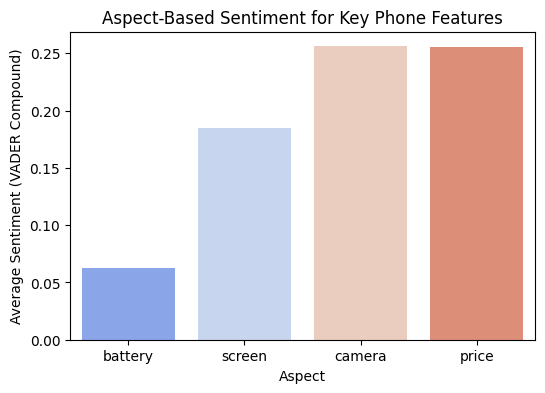

In [47]:
plt.figure(figsize=(6,4))
sns.barplot(data=aspect_df, x='Aspect', y='Average_Sentiment', palette='coolwarm')
plt.title("Aspect-Based Sentiment for Key Phone Features")
plt.ylabel("Average Sentiment (VADER Compound)")
plt.show()


 # G3.1 – Setup: Install & Load a Summarisation Model

In [48]:
# Install transformers if you haven't already
!pip install transformers sentencepiece

from transformers import pipeline
import pandas as pd


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable


In [49]:
# Option 1: BART (recommended)
summarizer = pipeline(
    "summarization",
    model="facebook/bart-large-cnn",
    tokenizer="facebook/bart-large-cnn"
)

# # Option 2: Smaller T5 model (faster but weaker)
# summarizer = pipeline(
#     "summarization",
#     model="t5-small",
#     tokenizer="t5-small"
# )


Device set to use cpu


In [50]:
# Filter to negative reviews
neg_df = df_sample[df_sample['Sentiment'] == "Negative"].copy()

print(f"Number of negative reviews: {len(neg_df)}")

# Use the original text for richer summaries
neg_texts = neg_df['Original'].astype(str).tolist()


Number of negative reviews: 403


In [51]:
def chunk_texts(text_list, max_chars=1500):
    """
    Concatenate a list of texts into character-based chunks no longer than max_chars.
    """
    chunks = []
    current = ""

    for t in text_list:
        if len(current) + len(t) + 1 <= max_chars:
            current += " " + t
        else:
            chunks.append(current.strip())
            current = t
    if current:
        chunks.append(current.strip())
    return chunks

neg_chunks = chunk_texts(neg_texts, max_chars=1500)
print("Number of chunks created:", len(neg_chunks))


Number of chunks created: 82


In [52]:
chunk_summaries = []

for i, ch in enumerate(neg_chunks):
    print(f"Summarising chunk {i+1}/{len(neg_chunks)}...")
    summary = summarizer(
        ch,
        max_length=80,   # approx. 1–2 sentences
        min_length=25,
        do_sample=False
    )[0]['summary_text']
    chunk_summaries.append(summary)

chunk_summaries[:5]


Summarising chunk 1/82...
Summarising chunk 2/82...
Summarising chunk 3/82...
Summarising chunk 4/82...
Summarising chunk 5/82...
Summarising chunk 6/82...
Summarising chunk 7/82...
Summarising chunk 8/82...
Summarising chunk 9/82...
Summarising chunk 10/82...
Summarising chunk 11/82...
Summarising chunk 12/82...
Summarising chunk 13/82...
Summarising chunk 14/82...
Summarising chunk 15/82...
Summarising chunk 16/82...
Summarising chunk 17/82...
Summarising chunk 18/82...
Summarising chunk 19/82...
Summarising chunk 20/82...
Summarising chunk 21/82...
Summarising chunk 22/82...
Summarising chunk 23/82...
Summarising chunk 24/82...
Summarising chunk 25/82...
Summarising chunk 26/82...
Summarising chunk 27/82...
Summarising chunk 28/82...
Summarising chunk 29/82...
Summarising chunk 30/82...
Summarising chunk 31/82...
Summarising chunk 32/82...
Summarising chunk 33/82...
Summarising chunk 34/82...
Summarising chunk 35/82...
Summarising chunk 36/82...
Summarising chunk 37/82...
Summarisin

['This phone does not work on Verizon. Has very little internal memo, even installing an external memory of 16GB can download programs, because they always need internal memory.',
 'LG G4 Unlocked Smartphone with 32GB Internal Memory, 16 MP Camera and 5.5-Inch IPS Quantum Display (Black Leather) Product is not compatible with Verizon. Verizon informed me during a CHAT session that the phone is GSM, not CDMA.',
 'One note, the picture with case is misleading Please remove it Phone was working just fine until battery decided to not take AC charge at all and was left stranded at the airport looking for loose change to make a pay phone call.',
 'This phone arrived with failed camera and AMAZON did a horriable job on packing. This phone was not US verison and came with EUR standard charger (not working well). Besides these defects, the camera failed once I started the machine. If youe open the camera,screen turned to completely black.',
 'The screen was partially melted in places but it pee

In [53]:
# BART's max input length is 1024 tokens (~1200-1500 characters)
max_model_input = 1200

all_summary_text = " ".join(chunk_summaries)

def safe_summarize(text, max_length=60, min_length=25):
    try:
        result = summarizer(
            text,
            max_length=max_length,
            min_length=min_length,
            do_sample=False
        )
        if result and 'summary_text' in result[0]:
            return result[0]['summary_text']
        else:
            return None
    except Exception as e:
        print(f"Error during summarization: {e}")
        return None

if len(all_summary_text) <= max_model_input:
    final_summary = safe_summarize(all_summary_text)
    if final_summary:
        print("Final summary of negative reviews:\n")
        print(final_summary)
    else:
        print("Summary could not be generated. The input may be too long for the model.")
else:
    # Split into smaller chunks and summarize each, then combine
    def split_text(text, max_chars):
        chunks = []
        current = ""
        for sentence in text.split('. '):
            if len(current) + len(sentence) + 2 <= max_chars:
                current += sentence + '. '
            else:
                chunks.append(current.strip())
                current = sentence + '. '
        if current:
            chunks.append(current.strip())
        return chunks

    summary_chunks = []
    for chunk in split_text(all_summary_text, max_model_input):
        summary = safe_summarize(chunk)
        if summary:
            summary_chunks.append(summary)
    final_summary = " ".join(summary_chunks)
    print("Final summary of negative reviews:\n")
    print(final_summary)


Final summary of negative reviews:

LG G4 Unlocked Smartphone with 32GB Internal Memory, 16 MP Camera and 5.5-Inch IPS Quantum Display (Black Leather) Product is not compatible with Verizon. The watch is internally set for GMT in which N.Y. is GMT-5:00 however nothing you can do to get it from AM to PM or vice versa. If you use the Stock digital face clock will be 24hrs off if you can set it at all. Verizon representative not only tried several times to get the phone to work, but also stated could see the phone had water damage. One of the phones is usable, but we can't use the camera or the voice mail because the previous owner had a password and we have no way to This phone stinks and is unreliable. Seems I bought a badly refurbished phone, not a new one. The phone calls were static and unclear due to the cheap quality of this device. A good entry level phone but apps kept quitting on me. The silence button is crooked. The camera wasn't as good and the audio wasn't good enough. I wou

We’ll now do topic-specific summarisation:

“Summarise negative reviews within each topic (e.g., battery topic, delivery topic, camera topic).”

I’ll assume you already have:

topic_model (BERTopic model from G1)

df_sample with:

Original (raw review text)

Sentiment (from VADER)

BERTopic_Topic (from topics returned by BERTopic)

1️⃣ Inspect Topics & Pick Interesting Ones

First, see what topics BERTopic has found and how many negative reviews each topic contains.

In [54]:
import pandas as pd

# Basic topic info from BERTopic
topic_info = topic_model.get_topic_info()
topic_info.head()


,Topic,Count,Name,Representation,Representative_Docs
0,-1,832,-1_the_and_phone_to,"[the, and, phone, to, it, is, this, for, with,...",[so far im pleasantly surprised by this phone ...
1,0,130,0_product_it_love it_love,"[product, it, love it, love, good, excellent, ...",[the product arrived on time and it was workin...
2,1,65,1_phone_great_love_great phone,"[phone, great, love, great phone, very, it, pr...","[very nice phone i love it, great phone for a ..."
3,2,54,2_camera_the_is_good,"[camera, the, is, good, and, quality, phone, g...",[this is such a good phone for the price it wa...
4,3,54,3_case_my_clip_otterbox,"[case, my, clip, otterbox, this, it, this case...",[i bought these for my father a little over a ...


In [55]:
# Count reviews per topic & sentiment
topic_sent_counts = (
    df_sample
    .groupby(['BERTopic_Topic', 'Sentiment'])
    .size()
    .reset_index(name='Count')
    .sort_values(['Sentiment', 'Count'], ascending=[True, False])
)

topic_sent_counts.head(20)


,BERTopic_Topic,Sentiment,Count
0,-1,Negative,194
15,4,Negative,26
24,7,Negative,24
3,0,Negative,15
38,12,Negative,13
35,11,Negative,12
21,6,Negative,11
68,24,Negative,9
12,3,Negative,8
82,29,Negative,8


In [56]:
topic_model.get_topic(0)   # e.g. battery-related
topic_model.get_topic(3)   # e.g. delivery/seller
topic_model.get_topic(5)   # e.g. camera/screen


[('the', np.float64(0.022446059913308277)),
 ('to', np.float64(0.02061472861975086)),
 ('keyboard', np.float64(0.018350130445555418)),
 ('and', np.float64(0.017178193428033516)),
 ('for', np.float64(0.016369005974657146)),
 ('my', np.float64(0.015727669724405768)),
 ('phone', np.float64(0.014797444034955812)),
 ('it', np.float64(0.014080717069009773)),
 ('the keyboard', np.float64(0.013095301311459672)),
 ('texting', np.float64(0.012320775954450804))]

2️⃣ Helper: Chunk + Summarise Texts for One Topic

We’ll reuse the summarizer and chunk_texts from before, but wrap them in a function that:

Filters reviews by topic ID and optional sentiment (e.g. Negative)

Chunks them

Summarises the chunks

Returns a final meta-summary

In [57]:
from transformers import pipeline

# If not already defined:
# summarizer = pipeline(
#     "summarization",
#     model="facebook/bart-large-cnn",
#     tokenizer="facebook/bart-large-cnn"
# )

def chunk_texts(text_list, max_chars=1500):
    chunks = []
    current = ""
    for t in text_list:
        t = str(t)
        if len(current) + len(t) + 1 <= max_chars:
            current += " " + t
        else:
            chunks.append(current.strip())
            current = t
    if current:
        chunks.append(current.strip())
    return chunks


def summarise_topic(df, topic_id, sentiment_filter="Negative",
                    chunk_size=1500, max_len=80, min_len=25):
    """
    Summarise reviews belonging to a specific BERTopic topic.
    Optionally filter by sentiment (e.g. Negative).
    """
    subset = df[df['BERTopic_Topic'] == topic_id]
    if sentiment_filter is not None:
        subset = subset[subset['Sentiment'] == sentiment_filter]
    
    texts = subset['Original'].dropna().astype(str).tolist()
    print(f"Topic {topic_id}: {len(texts)} reviews after filtering.")
    
    if len(texts) == 0:
        return None, []
    
    # 1) Chunk
    chunks = chunk_texts(texts, max_chars=chunk_size)
    print(f"Number of chunks: {len(chunks)}")
    
    # 2) Summarise each chunk
    chunk_summaries = []
    for i, ch in enumerate(chunks):
        print(f"Summarising chunk {i+1}/{len(chunks)} for topic {topic_id}...")
        summary = summarizer(
            ch,
            max_length=max_len,
            min_length=min_len,
            do_sample=False
        )[0]['summary_text']
        chunk_summaries.append(summary)
    
    # 3) Meta-summary (summary of summaries)
    if len(chunk_summaries) == 1:
        final_summary = chunk_summaries[0]
    else:
        all_summary_text = " ".join(chunk_summaries)
        final_summary = summarizer(
            all_summary_text,
            max_length=max_len,
            min_length=min_len,
            do_sample=False
        )[0]['summary_text']
    
    return final_summary, chunk_summaries


3️⃣ Generate Topic-Specific Summaries (e.g. Top 3 Negative Topics)

Once you’ve inspected topic_sent_counts, pick a few interesting topics.
Example: topics 0, 3, 5 are high in negative reviews.

In [58]:
topic_ids_of_interest = [0, 3, 5]  # replace with your actual topic IDs

topic_level_summaries = {}

for tid in topic_ids_of_interest:
    print("="*60)
    print(f"Summarising Topic {tid}")
    try:
        final_summary, chunk_summaries = summarise_topic(
            df_sample,
            topic_id=tid,
            sentiment_filter="Negative"
        )
    except IndexError as e:
        print(f"Error summarizing topic {tid}: {e}")
        final_summary, chunk_summaries = None, []
    topic_level_summaries[tid] = final_summary
    print("\nFinal summary for topic", tid, ":\n", final_summary, "\n")


Summarising Topic 0
Topic 0: 15 reviews after filtering.
Number of chunks: 2
Summarising chunk 1/2 for topic 0...
Summarising chunk 2/2 for topic 0...

Final summary for topic 0 :
 It was slow, nonresponsive the whole time, kept crashing. After the fourth day I couldn't take it. Would NOT recommend! It didn't work so I had to send it back. 

Summarising Topic 3
Topic 3: 8 reviews after filtering.
Number of chunks: 2
Summarising chunk 1/2 for topic 3...


Your max_length is set to 80, but your input_length is only 60. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)


Summarising chunk 2/2 for topic 3...

Final summary for topic 3 :
 The rubber, outer shell is crap and missing the "made in Mexico stamp" The plastic inner is also flimsy and I doubt it will protect my phone. Although the case is big the muted purple doesn't look bad. I love it. 

Summarising Topic 5
Topic 5: 6 reviews after filtering.
Number of chunks: 1
Summarising chunk 1/1 for topic 5...

Final summary for topic 5 :
 The phone didn't last two months before the touch screen was no longer operative. Difficult for my wife to use. Total waste of money unless all you want is phone/text. 



# PART G3.3 — Topic Strength vs Weakness Matrix (Heatmap)

In [59]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

df_sample['Compound'] = df_sample['Original'].apply(lambda x: sid.polarity_scores(str(x))['compound'])


In [60]:
import pandas as pd

topic_sentiment_stats = df_sample.groupby('BERTopic_Topic').agg(
    Avg_Compound=('Compound', 'mean'),
    Pos_Count=('Sentiment', lambda x: (x == 'Positive').sum()),
    Neg_Count=('Sentiment', lambda x: (x == 'Negative').sum()),
    Total=('Sentiment', 'count')
).reset_index()

topic_sentiment_stats['Pos_Ratio'] = topic_sentiment_stats['Pos_Count'] / topic_sentiment_stats['Total']
topic_sentiment_stats['Neg_Ratio'] = topic_sentiment_stats['Neg_Count'] / topic_sentiment_stats['Total']

topic_sentiment_stats


,BERTopic_Topic,Avg_Compound,Pos_Count,Neg_Count,Total,Pos_Ratio,Neg_Ratio
0,-1,0.362734,571,194,832,0.686298,0.233173
1,0,0.480998,106,15,130,0.815385,0.115385
2,1,0.643662,60,3,65,0.923077,0.046154
3,2,0.648231,47,4,54,0.870370,0.074074
4,3,0.469685,44,8,54,0.814815,0.148148
5,4,-0.027881,17,26,47,0.361702,0.553191
6,5,0.523626,35,6,43,0.813953,0.139535
7,6,0.354376,30,11,42,0.714286,0.261905
8,7,-0.179776,9,24,41,0.219512,0.585366
9,8,0.481111,21,0,28,0.750000,0.000000


In [61]:
heatmap_df = topic_sentiment_stats[['BERTopic_Topic', 'Pos_Ratio', 'Neg_Ratio']]
heatmap_df = heatmap_df.set_index('BERTopic_Topic')
heatmap_df


,Pos_Ratio,Neg_Ratio
BERTopic_Topic,,
-1,0.686298,0.233173
0,0.815385,0.115385
1,0.923077,0.046154
2,0.870370,0.074074
3,0.814815,0.148148
4,0.361702,0.553191
5,0.813953,0.139535
6,0.714286,0.261905
7,0.219512,0.585366


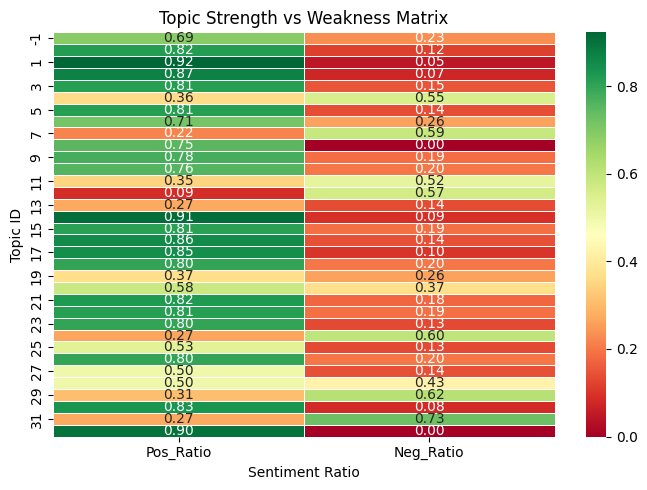

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 5))
sns.heatmap(
    heatmap_df,
    annot=True,
    cmap='RdYlGn',    # red = negative, green = positive
    linewidths=.5,
    fmt=".2f"
)
plt.title("Topic Strength vs Weakness Matrix")
plt.ylabel("Topic ID")
plt.xlabel("Sentiment Ratio")
plt.tight_layout()
plt.show()


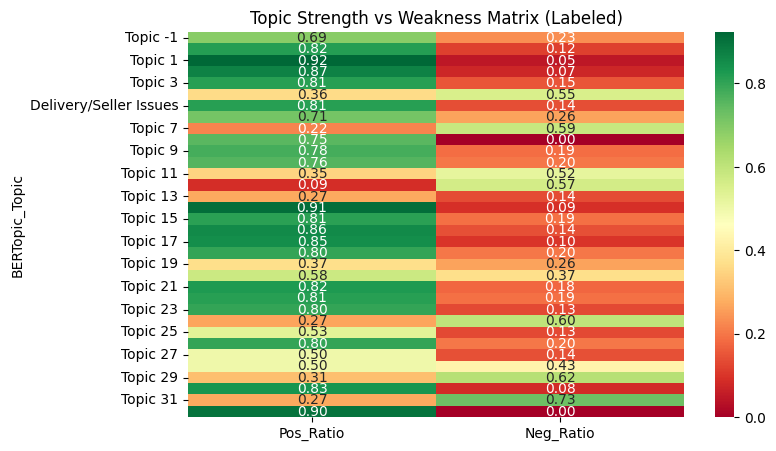

In [63]:
topic_labels = {
    0: "Battery",
    2: "Camera & Screen",
    5: "Delivery/Seller Issues",
    # add more...
}

heatmap_df_labeled = heatmap_df.copy()
heatmap_df_labeled.index = heatmap_df_labeled.index.map(lambda x: topic_labels.get(x, f"Topic {x}"))

plt.figure(figsize=(8, 5))
sns.heatmap(
    heatmap_df_labeled,
    annot=True,
    cmap="RdYlGn",
    fmt=".2f"
)
plt.title("Topic Strength vs Weakness Matrix (Labeled)")
plt.show()


# 🧠 Idea

For each BERTopic topic:

Collect representative text for that topic (either top documents or all docs in cluster).

Feed that text to KeyBERT.

Let KeyBERT extract the top keyword/phrase (1–3 words).

Use that phrase as an automatic topic name, e.g.:

Topic 0 → "battery life issues"

Topic 3 → "delivery and seller"

Topic 5 → "camera and screen quality"

In [64]:
!pip install keybert

from keybert import KeyBERT
from sentence_transformers import SentenceTransformer
import pandas as pd


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable


In [65]:
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
kw_model = KeyBERT(model=embedding_model)


In [66]:
# Get topic info from BERTopic
topic_info = topic_model.get_topic_info()
topic_ids = topic_info[topic_info['Topic'] != -1]['Topic'].tolist()  # exclude outliers (-1)

def build_topic_corpus(df, topic_id, max_docs=1000):
    """
    Concatenate up to max_docs reviews belonging to a given topic
    into a single large text string.
    """
    subset = df[df['BERTopic_Topic'] == topic_id]['Original'].dropna().astype(str)
    if len(subset) > max_docs:
        subset = subset.sample(n=max_docs, random_state=42)
    return " ".join(subset.tolist())


topic_corpora = {
    tid: build_topic_corpus(df_sample, tid, max_docs=300)   # 300 docs per topic is usually enough
    for tid in topic_ids
}


In [67]:
topic_labels_auto = {}

for tid, text in topic_corpora.items():
    if not text.strip():
        topic_labels_auto[tid] = f"Topic {tid}"
        continue
    
    keywords = kw_model.extract_keywords(
        text,
        keyphrase_ngram_range=(1, 3),  # allow 1–3 word phrases
        stop_words='english',
        top_n=5
    )
    # keywords is list of (phrase, score)
    best_label = keywords[0][0] if keywords else f"Topic {tid}"
    topic_labels_auto[tid] = best_label

topic_labels_auto


{0: 'problem product italy',
 1: 'fantastic value phone',
 2: 'decent camera phone',
 3: 'protection phone otterbox',
 4: 'scratches came charger',
 5: 'phone great texting',
 6: 'blackberry brand new',
 7: 'phone failings charger',
 8: 'fast delivery excellent',
 9: 'att great phone',
 10: 'phone use venezuela',
 11: 'product phone ok',
 12: 'item working stopped',
 13: 'excelente teléfono gama',
 14: 'mobile lte',
 15: 'straight talk verizon',
 16: 'recommend blu phone',
 17: 'big cell phone',
 18: 'memory good phone',
 19: 'unlocked verizon phone',
 20: 'phones hearing ring',
 21: 'face clock 24hrs',
 22: 'worst purchase phones',
 23: 'mom loves iphone5s',
 24: 'dual sim phone',
 25: 'g1 phone',
 26: 'phone battery life',
 27: 'international sim card',
 28: 'junk returned phone',
 29: 'battery replaced phone',
 30: 'nokia lumia',
 31: 'fix phone buy',
 32: 'excellent basic phone'}

In [68]:
labels_df = pd.DataFrame({
    "Topic_ID": list(topic_labels_auto.keys()),
    "Auto_Label": list(topic_labels_auto.values())
}).sort_values("Topic_ID")

labels_df


,Topic_ID,Auto_Label
0,0,problem product italy
1,1,fantastic value phone
2,2,decent camera phone
3,3,protection phone otterbox
4,4,scratches came charger
5,5,phone great texting
6,6,blackberry brand new
7,7,phone failings charger
8,8,fast delivery excellent
9,9,att great phone


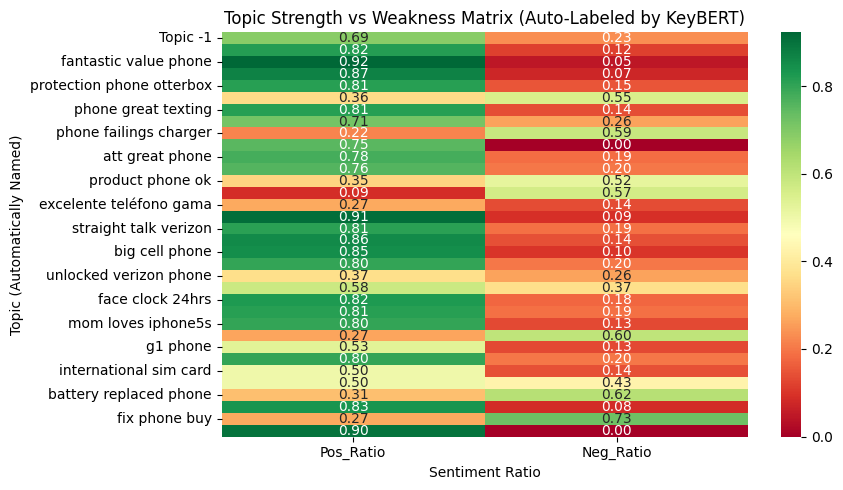

In [69]:
heatmap_df_labeled = heatmap_df.copy()
heatmap_df_labeled.index = heatmap_df_labeled.index.map(
    lambda x: topic_labels_auto.get(x, f"Topic {x}")
)

plt.figure(figsize=(9, 5))
sns.heatmap(
    heatmap_df_labeled,
    annot=True,
    cmap="RdYlGn",
    fmt=".2f"
)
plt.title("Topic Strength vs Weakness Matrix (Auto-Labeled by KeyBERT)")
plt.ylabel("Topic (Automatically Named)")
plt.xlabel("Sentiment Ratio")
plt.tight_layout()
plt.show()


In [70]:
df_sample['Topic_Label'] = df_sample['BERTopic_Topic'].map(topic_labels_auto)
df_sample[['Original', 'BERTopic_Topic', 'Topic_Label']].head()


,Original,BERTopic_Topic,Topic_Label
0,Same features as my wife's iPhone 6.at a third...,23,mom loves iphone5s
1,This phone is good but some of the apps aren't...,18,memory good phone
2,Love this phone! bought the same model to repl...,5,phone great texting
3,"Shipped very fast, great phone",8,fast delivery excellent
4,"Nice product, arrived on time , would recommend!",0,problem product italy


We’ll build an interactive Plotly PCA scatterplot where you can:

Colour points by Sentiment

Hover to see: review text, topic label, topic id, maybe star rating

Use your auto topic labels from KeyBERT

In [71]:
!pip install plotly


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable


In [72]:
import plotly.express as px
import pandas as pd


In [73]:
# Ensure we only use rows that have PCA + topic labels
plot_df = df_sample.dropna(subset=['PC1', 'PC2', 'Topic_Label', 'Sentiment']).copy()

# Optional: shorten reviews for hover (to avoid super long tooltips)
def truncate_text(text, max_len=200):
    text = str(text)
    return text if len(text) <= max_len else text[:max_len] + "..."

plot_df['Review_Short'] = plot_df['Original'].apply(truncate_text)

fig = px.scatter(
    plot_df,
    x='PC1',
    y='PC2',
    color='Sentiment',   # colour by sentiment
    hover_data={
        'Review_Short': True,
        'Topic_Label': True,
        'BERTopic_Topic': True,
        'Sentiment': True,
        'PC1': False,    # hide these numeric values in hover if you want
        'PC2': False
    },
    title="Interactive PCA of TF-IDF Reviews (Hover: Topic, Sentiment, Review)",
    opacity=0.7
)

fig.update_traces(marker=dict(size=6))

fig.update_layout(
    legend_title_text="Sentiment",
    hoverlabel=dict(bgcolor="white", font_size=11),
    xaxis_title="Principal Component 1",
    yaxis_title="Principal Component 2"
)

fig.show()


In [74]:
fig_topic = px.scatter(
    plot_df,
    x='PC1',
    y='PC2',
    color='Topic_Label',
    hover_data={
        'Review_Short': True,
        'Sentiment': True,
        'Topic_Label': False,
        'BERTopic_Topic': True
    },
    title="Interactive PCA of Reviews (Coloured by Topic, Hover for Sentiment)",
    opacity=0.7
)

fig_topic.update_traces(marker=dict(size=6))
fig_topic.update_layout(
    legend_title_text="Topic (KeyBERT Label)",
    xaxis_title="Principal Component 1",
    yaxis_title="Principal Component 2"
)

fig_topic.show()
# fig_topic.write_html("pca_interactive_by_topic.html")


In [75]:
# Install if not already done
!pip install transformers torch --quiet

from transformers import pipeline
import pandas as pd


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [76]:
from transformers import pipeline

# Emotion classification pipeline
emotion_classifier = pipeline(
    "text-classification",
    model="j-hartmann/emotion-english-distilroberta-base",
    return_all_scores=False  # just get the top emotion
)


Device set to use cpu


In [77]:
# Work on a subset for speed
emo_subset = df_sample.sample(n=min(1000, len(df_sample)), random_state=42).copy()

def detect_emotion(text):
    text = str(text)
    # truncate very long reviews to avoid hitting model token limits
    text = text[:512]
    result = emotion_classifier(text)[0]
    return result['label'], result['score']

emo_subset[['Emotion', 'Emotion_Score']] = emo_subset['Original'].apply(
    lambda t: pd.Series(detect_emotion(t))
)

emo_subset[['Original', 'Emotion', 'Emotion_Score']].head()


,Original,Emotion,Emotion_Score
1559,"I am very disappointed, the phone looks new, t...",sadness,0.916052
212,I purchased a T-mobile one from a seller and t...,sadness,0.392444
1682,"It is OK, maybe it is to soon to review it, si...",neutral,0.945181
836,"Sweet! Like the packaging, fits perfectly... I...",joy,0.539953
1245,I believe this is the best phone on the price ...,joy,0.669006


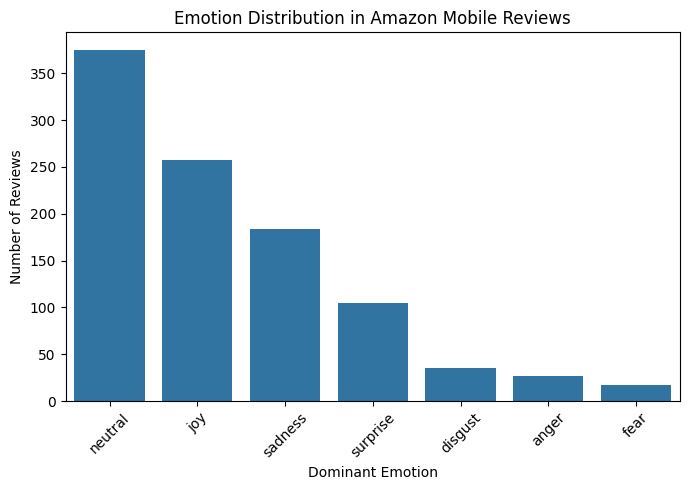

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(7,5))
sns.countplot(data=emo_subset, x='Emotion', order=emo_subset['Emotion'].value_counts().index)
plt.title("Emotion Distribution in Amazon Mobile Reviews")
plt.xlabel("Dominant Emotion")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


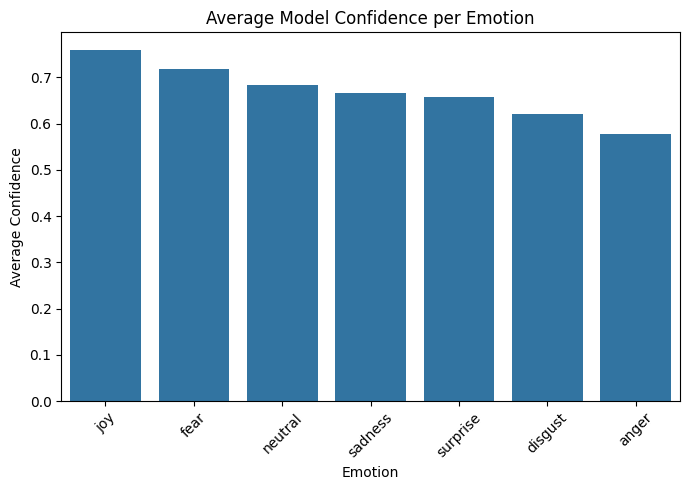

In [79]:
emotion_conf = (
    emo_subset.groupby('Emotion')['Emotion_Score']
    .mean()
    .reset_index()
    .sort_values('Emotion_Score', ascending=False)
)

plt.figure(figsize=(7,5))
sns.barplot(data=emotion_conf, x='Emotion', y='Emotion_Score')
plt.title("Average Model Confidence per Emotion")
plt.ylabel("Average Confidence")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
